In [2]:
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [42]:
def get_ohlcv_data(ticker_symbol, period="1y", interval="1d"):
    try:
        # Create a Ticker object
        ticker = yf.Ticker(ticker_symbol)

        # Download historical data
        # yfinance automatically returns OHLCV data
        print(f"Fetching {period} of {interval} data for {ticker_symbol}...")
        data = ticker.history(period=period, interval=interval)

        # Check if the dataframe is empty
        if data.empty:
            print(f"Error: No data found for ticker '{ticker_symbol}'. It might be an invalid ticker.")
            return None

        # The columns are already named 'Open', 'High', 'Low', 'Close', 'Volume'
        # 'Dividends' and 'Stock Splits' are also included by default
        return data

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

if __name__ == "__main__":
    # Set the ticker you want to analyze
    # Examples: 'AAPL' (Apple), 'GOOGL' (Google), 'MSFT' (Microsoft), 'TSLA' (Tesla)
    target_ticker = 'AAPL'

    # Fetch the data
    ohlcv_df = get_ohlcv_data(target_ticker, period="5y")

    # Display the data if fetching was successful
    if ohlcv_df is not None:
        print(f"\nSuccessfully downloaded data for {target_ticker}.")
        print("\n--- Data Info ---")
        ohlcv_df.info()

Fetching 5y of 1d data for AAPL...

Successfully downloaded data for AAPL.

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-07-10 00:00:00-04:00 to 2025-07-10 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1256 non-null   float64
 1   High          1256 non-null   float64
 2   Low           1256 non-null   float64
 3   Close         1256 non-null   float64
 4   Volume        1256 non-null   int64  
 5   Dividends     1256 non-null   float64
 6   Stock Splits  1256 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.5 KB


In [46]:
df = ohlcv_df.drop(['Volume','Dividends', 'Stock Splits'], axis=1)
# Keep only the date part (no time, no timezone)
df = df.reset_index()
df['Date'] = df['Date'].dt.date
df = df.set_index('Date')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1256 entries, 2020-07-10 to 2025-07-10
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1256 non-null   float64
 1   High    1256 non-null   float64
 2   Low     1256 non-null   float64
 3   Close   1256 non-null   float64
dtypes: float64(4)
memory usage: 49.1+ KB


In [57]:
endog = df['Low']
exog = df.drop(columns=['Low'])

### 12 Months

Split 1: RMSE = 5.36
Split 1: RMSLE = 0.03
Split 2: RMSE = 2.07
Split 2: RMSLE = 0.01
Split 3: RMSE = 4.79
Split 3: RMSLE = 0.03
Split 4: RMSE = 17.87
Split 4: RMSLE = 0.07
Split 5: RMSE = 51.59
Split 5: RMSLE = 0.33

Average validation RMSE: 16.33

Test RMSLE (250 steps): 0.03
Test MAPE: 2.10%


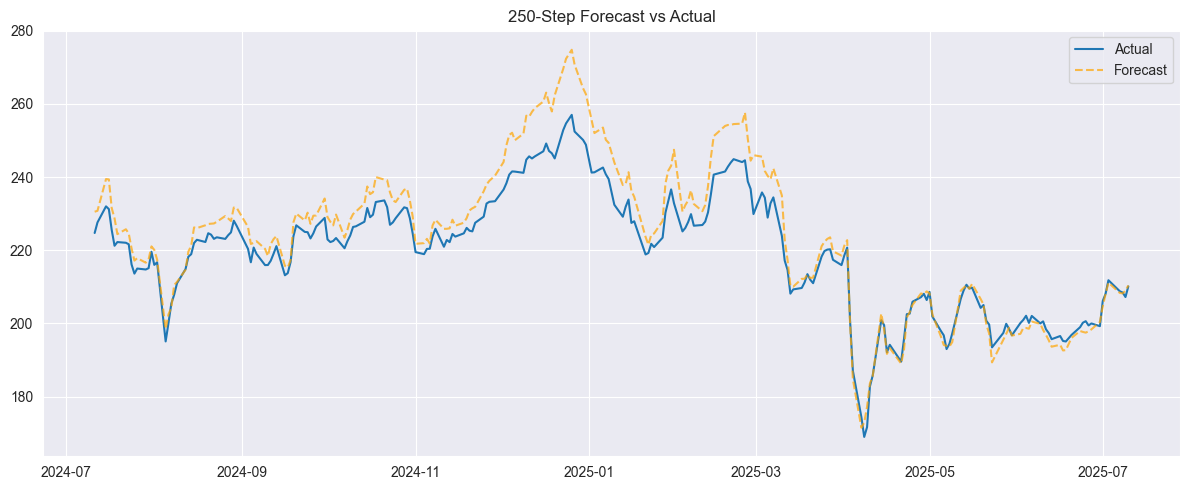

In [58]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, root_mean_squared_log_error
import matplotlib.pyplot as plt

# --- Assume endog and exog are already defined ---

use_log_transform = True  # <-- Set to False to disable log1p

# --- Optional log1p transform ---
if use_log_transform:
    endog_transformed = np.log1p(endog)
else:
    endog_transformed = endog.copy()

# Ensure datetime index
endog.index = pd.to_datetime(endog.index)
exog.index = pd.to_datetime(exog.index)

# Set forecast start date
forecast_start_date = pd.to_datetime("2024-07-11")

# Find how many days into the future we want to forecast
last_obs_date = endog.index[-1]

# Train on all available historical data
train_endog = endog_transformed.copy()
train_exog = exog.loc[train_endog.index]

# Forecast horizon: from 2024-07-11 to end of exog
forecast_exog = exog.loc[forecast_start_date:]
forecast_steps = len(forecast_exog)

# Ground truth for test evaluation
if use_log_transform:
    true_test = endog.loc[forecast_start_date:]
else:
    true_test = endog.loc[forecast_start_date:]

# SARIMA parameters
p, d, q = 3, 0, 2
P, D, Q = 2, 1, 1
s = 7  # Weekly seasonality

# --- Expanding window cross-validation ---
n_splits = 5
min_train_size = int(len(train_endog) * 0.2)
val_scores = []

for i in range(n_splits):
    split_point = min_train_size + int((len(train_endog) - min_train_size) * (i / n_splits))
    val_size = int(len(train_endog) * 0.25)

    sub_train_endog = train_endog.iloc[:split_point]
    sub_val_endog = train_endog.iloc[split_point:split_point + val_size]
    sub_train_exog = train_exog.iloc[:split_point]
    sub_val_exog = train_exog.iloc[split_point:split_point + val_size]

    try:
        model = SARIMAX(sub_train_endog,
                        exog=sub_train_exog,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=False)

        forecast_log = model_fit.forecast(steps=len(sub_val_endog), exog=sub_val_exog)

        # Inverse-transform and clip
        if use_log_transform:
            forecast = np.exp(forecast_log) - 1
            forecast = np.clip(forecast, 0, None)
            true_vals = np.expm1(sub_val_endog)
        else:
            forecast = forecast_log
            true_vals = sub_val_endog

        rmse = root_mean_squared_error(true_vals, forecast)
        rmsle = root_mean_squared_log_error(true_vals, forecast)
        val_scores.append(rmse)

        print(f"Split {i+1}: RMSE = {rmse:.2f}")
        print(f"Split {i+1}: RMSLE = {rmsle:.2f}")
    except Exception as e:
        print(f"Split {i+1} failed. Error: {e}")
        val_scores.append(np.nan)

print(f"\nAverage validation RMSE: {np.nanmean(val_scores):.2f}")

# --- Final model ---
final_model = SARIMAX(train_endog,
                      exog=train_exog,
                      order=(p, d, q),
                      seasonal_order=(P, D, Q, s),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_model_fit = final_model.fit(disp=False)

# --- Forecast on future data ---
forecast_log = final_model_fit.forecast(steps=forecast_steps, exog=forecast_exog)

if use_log_transform:
    forecast = np.exp(forecast_log) - 1
    forecast = np.clip(forecast, 0, None)
else:
    forecast = forecast_log

# Align the true test values (for evaluation)
true_test = true_test.loc[forecast_exog.index]

# --- Evaluate forecast ---
test_rmsle = root_mean_squared_log_error(true_test, forecast)
test_mape = mean_absolute_percentage_error(true_test, forecast)

print(f"\nTest RMSLE ({forecast_steps} steps): {test_rmsle:.2f}")
print(f"Test MAPE: {test_mape * 100:.2f}%")

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.plot(true_test.index, true_test, label="Actual")
plt.plot(true_test.index, forecast, label="Forecast", linestyle='--', color='orange', alpha=0.7)
plt.title(f"{forecast_steps}-Step Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


In [62]:
# --- SAVE THE FITTED MODEL ---
model_filepath = "aapl_low_sarimax.pkl"
final_model_fit.save(model_filepath)

In [61]:
df.to_csv('AAPL_2020_07_10_to_2025_07_10.csv', index=True, encoding='utf-8')